In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
## get data
import readcsv
data = readcsv.get_data().astype(np.float32)
print(data.shape)

(18628, 87)


In [7]:
## split into training, validation, and testing sets
data_train = data[:-2000, 2:3]
data_val = data[-2000:-1000, 2:3]
data_test = data[-1000:, 2:3]
print("Training:", data_train.shape)
print("Validation:", data_val.shape)
print("Testing:", data_test.shape)

Training: (16628, 1)
Validation: (1000, 1)
Testing: (1000, 1)


In [5]:
def generate_batches_X(data, batch_size, 
                     history=np.arange(100), 
                     forecast=np.arange(5), 
                     seed=0):
    """
    Given data, generate batches of intervals, without replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - history: array of history indices to learn from.
    - forecast: array of forecast indices to predict.
    - seed: seed for RNG
    
    returns: generator that yields (X, y)
    - X: array, shape = (B, len(history), C)
    - y: array, shape = (B, len(forecast))
    """
    
    np.random.seed(seed)
    history = np.array(history)
    forecast = np.array(forecast)
    
    N, C = data.shape
    H_max = int(np.max(history))
    F_max = int(np.max(forecast))
    
    X = np.zeros((batch_size, len(history), C))
    y = np.zeros((batch_size, len(forecast)))
    
    i = 0   ## tracks index
    k = 0   ## counts batch
    M = N - H_max - F_max - 1   ## ceiling for i
    while True:
        
        if k==batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+history]
        y[k] = data[i+H_max+1+forecast, 0] ## USD-EUR Close is index 0
        
        k += 1

## test
G = generate_batches(data_train, 7)

X, y = next(G)
print(X.shape)
print(y.shape)

(7, 100, 1)
(7, 5)


In [8]:
def generate_batches(data, batch_size, 
                     history, 
                     forecast, 
                     seed=0):
    """
    Given data, generate batches of intervals, without replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - history: array of history indices to learn from.
    - forecast: array of forecast indices to predict.
    - seed: seed for RNG
    
    returns: generator that yields (X, y)
    - X: array, shape = (B, len(history), C)
    - y: array, shape = (B, len(forecast))
    """
    
    np.random.seed(seed)
    
    N, C = data.shape
    
    X = np.zeros((batch_size, history, C))
    y = np.zeros((batch_size, forecast))
    
    i = 0   ## tracks index
    k = 0   ## counts batch
    M = N - history - forecast   ## ceiling for i
    while True:
        
        if k==batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i:i+history]
        y[k] = data[i+history:i+history+forecast, 0] ## USD-EUR Close is index 0
        
        k += 1

## test
G = generate_batches(data_train, 7, 100, 5)

X, y = next(G)
print(X.shape)
print(y.shape)

(7, 100, 1)
(7, 5)


In [9]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

## ===== model hyperparameters ======================
#history = np.arange(100)
#forecast = np.arange(0, 100, 10)   ## 10 predictions every 10-days 
history = 100
forecast = 5
## ==================================================

In [10]:
## generate validation and testing sets
G = generate_batches(data_val, 100, history, forecast, seed=1)
X_val, y_val = next(G)

G = generate_batches(data_test, 100, history, forecast, seed=2)
X_test, y_test = next(G)

In [11]:
## ===== optimizer ==================================
initial_learning_rate = 5e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

H = history
C = data_train.shape[1]
F = forecast

model = models.Sequential()
model.add(layers.AveragePooling1D(5, input_shape=(H, C)))
model.add(layers.LSTM(16))
model.add(layers.Dense(F))
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling1d (AveragePo (None, 20, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 1,237
Trainable params: 1,237
Non-trainable params: 0
_________________________________________________________________


In [12]:
## train on one data point
G = generate_batches(data_train, 1, history, forecast, seed=0)
X, y = next(G)

model.fit(X, y, batch_size=1)
model.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 968ms/sample - loss: 0.7391


0.739076554775238

In [ ]:
## train!
G = generate_batches(data_train, 50, history, forecast, seed=0)

model.fit(G, steps_per_epoch=300, epochs=20, validation_data=(X_val, y_val))

Train for 300 steps, validate on 100 samples
Epoch 1/20
300/300 [==============================] - 15s 51ms/step - loss: 0.0235 - val_loss: 6.2568e-04
Epoch 2/20
300/300 [==============================] - 12s 41ms/step - loss: 4.4255e-04 - val_loss: 2.3668e-04
Epoch 3/20
156/300 [==============>...............] - ETA: 6s - loss: 3.5920e-04

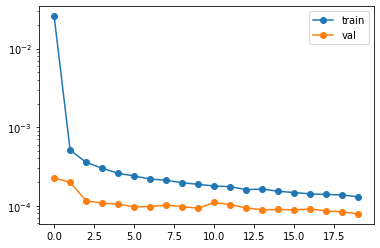

In [12]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.yscale('log')
plt.legend()
plt.show()

In [22]:
actual = np.arange(5)
G = generate_batches(data_test, 20, history, actual, seed=123)
X, y = next(G)

yhat = model.predict(X)
ytarget = y[:, forecast]

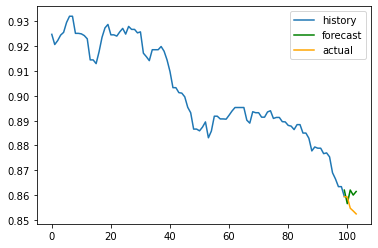

MSE: 3.805e-05


In [27]:
i = 5

mse = np.mean(np.square(yhat[i] - ytarget[i]))

H_max = int(np.max(history))
plt.plot(history, X[i,:,0], label='history')
plt.plot(H_max+forecast, yhat[i], label='forecast', color='green')
plt.plot(H_max+actual, y[i], label='actual', color='orange')
plt.legend()
plt.show()
print("MSE: %.3e" % mse)